## Loading the data

In this step I load only the modelling data which is the cleaned dataset without the demo set so that makes it 7431 audio recordings in total.

In [17]:
import pandas as pd

df = pd.read_csv("modelling_metadata.csv")
df.head()
df.shape

(7431, 10)

## Imports and configuration

In [2]:
import os
import numpy as np

# Audio settings
SAMPLE_RATE = 16000
DURATION_SEC = 3.0
TARGET_SAMPLES = int(SAMPLE_RATE * DURATION_SEC)

# Spectrogram settings
N_FFT = 1024
HOP_LENGTH = 256
N_MELS = 128

# Expected time frames
TARGET_FRAMES = 1 + (TARGET_SAMPLES // HOP_LENGTH)

# Output folders
OUT_NPY_DIR = "mel_npy"
OUT_PNG_DIR = "mel_png"
os.makedirs(OUT_NPY_DIR, exist_ok=True)
os.makedirs(OUT_PNG_DIR, exist_ok=True)

In this step, I define the audio and spectrogram configuration used to convert speech into fixed-size log-mel spectrograms for a CNN + BiLSTM model. I resample all audio to 16 kHz and trim or pad them to a duration of 3 seconds so that every input has the same length. I compute log-mel spectrograms using 128 mel bands and a fixed hop length, which ensures a consistent time dimension required by the BiLSTM. I also create output directories for saving spectrograms as .npy files for training and .png files for visualization, ensuring a clean and reproducible data preparation pipeline.

## Loading and normalizing audio length

In [3]:
import librosa

def load_and_fix_length(path, sample_rate=SAMPLE_RATE, target_samples=TARGET_SAMPLES):
    y, sr = librosa.load(path, sr=None)

    # ensure mono audio
    if y.ndim > 1:
        y = np.mean(y, axis=0)

    # resampling only if needed
    if sr != sample_rate:
        y = librosa.resample(y, orig_sr=sr, target_sr=sample_rate)

    # padding or trimming to fixed length
    if len(y) < target_samples:
        y = np.pad(y, (0, target_samples - len(y)), mode="constant")
    else:
        y = y[:target_samples]

    return y


I use this function to load each audio file, convert it to mono if necessary, resample it to a fixed sample rate, and pad or trim it to a fixed duration. By enforcing a consistent waveform length, I ensure that all generated log-mel spectrograms have the same shape and are compatible with the CNN + BiLSTM model.

## Why is fixed-length audio required?
Neural networks require inputs of consistent shape. By trimming or padding each audio clip to a fixed duration, I ensure that all resulting mel spectrograms have the same time dimension, which simplifies batching and allows the BiLSTM to process temporal information without variable-length handling.

## Why stereo audio is converted to mono?
Stereo audio is converted to mono to ensure consistent input shape and because spatial information is not relevant for speech emotion recognition. Emotional cues are primarily encoded in pitch, energy and timing rather than channel differences.

## Converting waveform into log-Mel spectrogram

In [4]:
def wav_to_logmel(y, sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=2.0
    )

    S_db = librosa.power_to_db(S, ref=np.max)

    # per-sample standardization
    S_norm = (S_db - S_db.mean()) / (S_db.std() + 1e-6)

    # output shape for PyTorch CNN: (1, n_mels, time)
    return S_norm[np.newaxis, :, :].astype(np.float32)


I use this function to convert a fixed-length audio signal into a log-mel spectrogram that is suitable for CNN + BiLSTM training. By applying log scaling and normalization and returning the spectrogram in a channel-first format, I ensure that all inputs are numerically stable, consistent in shape and directly compatible with PyTorch models.

**The steps taken:**

Take the raw audio waveform as input

Split the audio into short overlapping frames

Transform each frame into the frequency domain

Map frequencies onto the mel scale

Compute power (energy) for each mel band

Convert power values to decibels (log scaling)

Normalize the spectrogram per sample

Add a channel dimension for CNN input

Convert the output to float32 for PyTorch

## Why log scaling is applied?
Neural networks require inputs of consistent shape. By trimming or padding each audio clip to a fixed duration, I ensure that all resulting mel spectrograms have the same time dimension, which simplifies batching and allows the BiLSTM to process temporal information without variable-length handling.

## Saving a PNG preview image

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

def save_logmel_png(mel_img, out_path):
    # mel_img shape: (1, n_mels, time)
    S_img = np.squeeze(mel_img, axis=0)

    plt.figure(figsize=(4, 4))
    librosa.display.specshow(S_img)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig(out_path, dpi=150, bbox_inches="tight", pad_inches=0)
    plt.close()


I use this function to save a log-mel spectrogram as a clean PNG image for visualization and inspection. By removing the channel dimension and disabling all axes and padding, I ensure that the saved image contains only the spectrogram content, while keeping the NPY files as the primary input for CNN + BiLSTM training.

## Converting and saving all files

In [6]:
max_files = None
SAVE_PNG = True
LOG_EVERY = 500           # progress printing frequency

rows = df if max_files is None else df.head(max_files)

for i, row in enumerate(rows.itertuples(index=False), start=1):
    wav_path = row.file_path
    file_name = os.path.splitext(os.path.basename(wav_path))[0]

    try:
        # loading audio and enforcing fixed length
        y = load_and_fix_length(wav_path)

        # converting to log-mel in the agreed format (1, n_mels, T)
        mel_img = wav_to_logmel(y)

        # saving NPY
        np.save(os.path.join(OUT_NPY_DIR, f"{file_name}.npy"), mel_img)

        # saving PNG
        if SAVE_PNG:
            save_logmel_png(mel_img, os.path.join(OUT_PNG_DIR, f"{file_name}.png"))

    except Exception as e:
        print(f"Skipping file due to error: {wav_path}\n  -> {e}")
        continue

    if i % LOG_EVERY == 0:
        print(f"Processed {i} files...")

print("Saved NPY spectrograms to:", OUT_NPY_DIR)
if SAVE_PNG:
    print("Saved PNG previews to:", OUT_PNG_DIR)


Processed 500 files...
Processed 1000 files...
Processed 1500 files...
Processed 2000 files...
Processed 2500 files...
Processed 3000 files...
Processed 3500 files...
Processed 4000 files...
Processed 4500 files...
Processed 5000 files...
Processed 5500 files...
Processed 6000 files...
Processed 6500 files...
Processed 7000 files...
Saved NPY spectrograms to: mel_npy
Saved PNG previews to: mel_png


I use this block to iterate through the dataset, convert each audio file into a fixed-length log-mel spectrogram and save it as a .npy file for model training, with optional PNG output for visualization. By overwriting or regenerating files in a controlled way, I ensure that all saved spectrograms follow the same preprocessing rules and are fully consistent with the CNN + BiLSTM pipeline.

## Why are NPY files used instead of images?
Spectrograms are saved as NumPy arrays rather than images to preserve exact numerical values and the true temporal structure of the signal. This format is more suitable for sequence-based models such as BiLSTMs and avoids artifacts introduced by image rendering.

## Why CNN + BiLSTM is used?
The CNN is responsible for learning local spectral patterns from the mel spectrogram, while the BiLSTM models how these patterns evolve over time. This combination allows the system to capture both short-term acoustic features and long-term emotional dynamics.

## Visualising a random Mel spectrogram

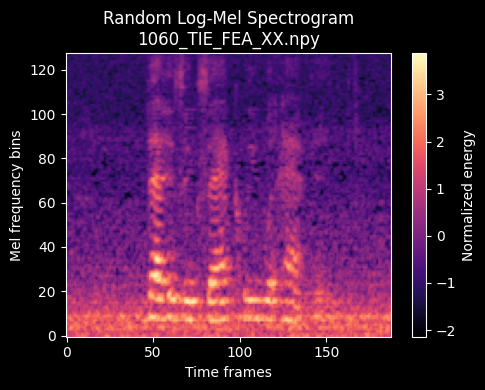

In [6]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# path to spectrogram folder
NPY_DIR = "mel_npy"

# picking a random .npy file
npy_files = [f for f in os.listdir(NPY_DIR) if f.endswith(".npy")]
random_file = random.choice(npy_files)

# loading spectrogram
spec = np.load(os.path.join(NPY_DIR, random_file))

# removing channel dimension if present
if spec.ndim == 3:
    spec = spec[0]

# plotting
plt.figure(figsize=(5, 4))
plt.imshow(spec, aspect="auto", origin="lower", cmap="magma")
plt.title(f"Random Log-Mel Spectrogram\n{random_file}")
plt.xlabel("Time frames")
plt.ylabel("Mel frequency bins")
plt.colorbar(label="Normalized energy")
plt.tight_layout()
plt.show()


A log-Mel spectrogram is a visual representation of how speech energy is distributed across frequency and time and it can be read as a map of how a spoken utterance unfolds acoustically. The horizontal axis represents time, moving from the beginning of the utterance on the left to the end on the right. Each vertical slice corresponds to a very short window of speech, so changes along this axis reflect how the signal evolves as the speaker talks. The vertical axis represents frequency on the Mel scale, which is designed to match human auditory perception: lower frequencies at the bottom correspond mainly to pitch and voicing, while higher frequencies toward the top capture consonants, noise and breathiness.

The color at each point encodes the amount of acoustic energy in that frequency band at that moment in time. Brighter colors indicate higher energy, while darker colors indicate low energy or silence. Because the spectrogram is shown on a logarithmic and normalized scale, the emphasis is on relative patterns rather than absolute loudness, which is important for analyzing emotion rather than volume.

Several characteristic patterns are especially informative. Horizontal bands near the bottom of the spectrogram indicate harmonics, which arise from voiced speech and reflect the speaker’s pitch. The spacing and stability of these bands give clues about pitch height and pitch variability, both of which are strongly influenced by emotion. Vertical bright regions correspond to syllables or stressed sounds, showing where speech energy is concentrated in time and revealing the rhythm of the utterance. Dark vertical gaps represent pauses or reduced energy, which can indicate breathing, hesitations or boundaries between words and phrases.

## Visualising and comparing the six emotions in the dataset

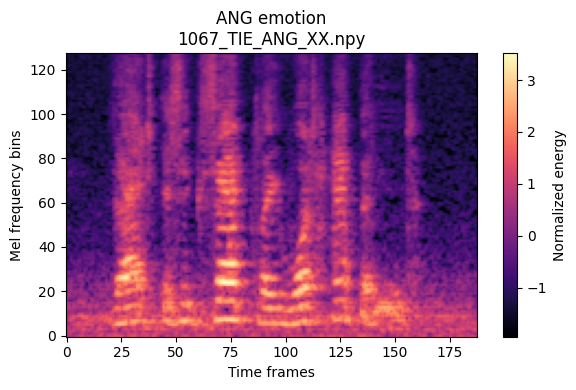

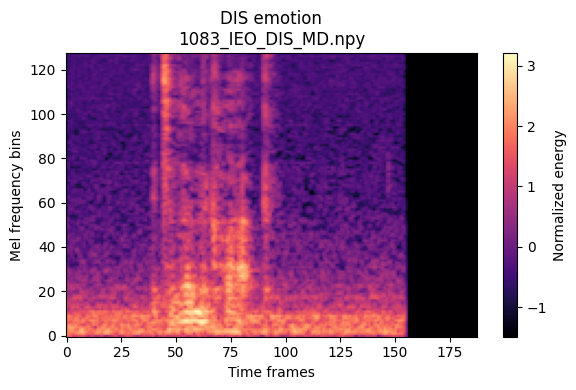

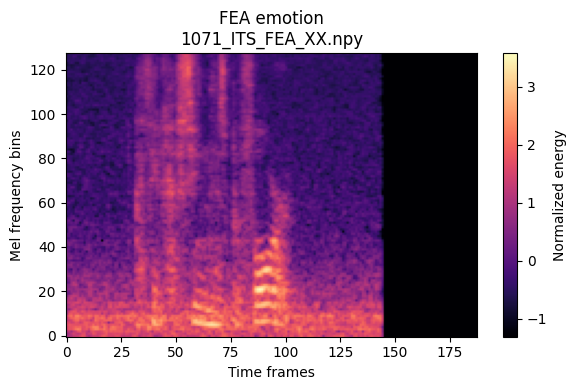

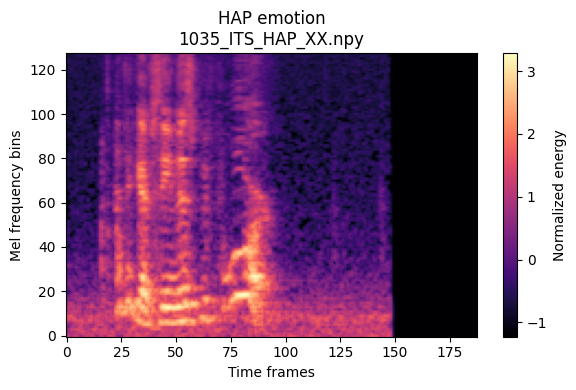

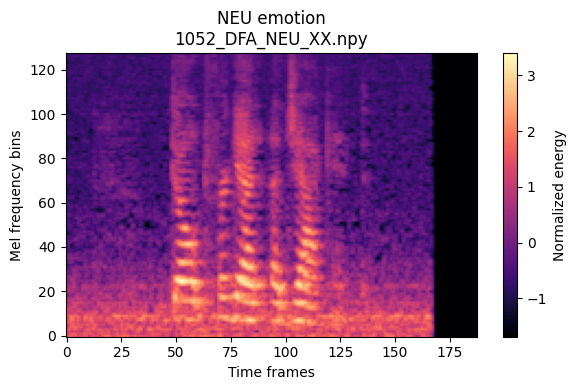

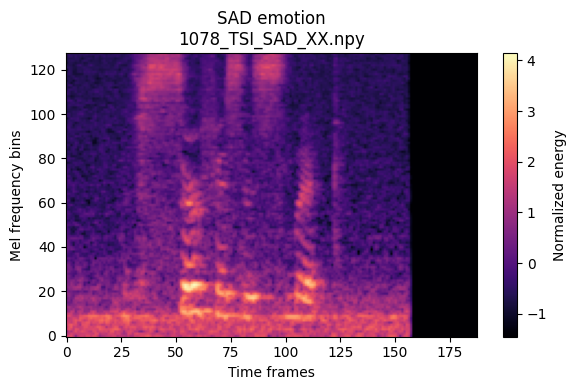

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# path to spectrogram folder
NPY_DIR = "mel_npy"

# listing all npy files
npy_files = [f for f in os.listdir(NPY_DIR) if f.endswith(".npy")]

EMOTIONS = ["ANG", "DIS", "FEA", "HAP", "NEU", "SAD"]

for emo in EMOTIONS:
    # picking one random file for this emotion
    candidates = [f for f in npy_files if f"_{emo}_" in f]
    if len(candidates) == 0:
        print(f"No files found for {emo}")
        continue

    fname = random.choice(candidates)
    spec = np.load(os.path.join(NPY_DIR, fname))

    # removing channel dimension if present
    if spec.ndim == 3:
        spec = spec[0]

    # plotting
    plt.figure(figsize=(6, 4))
    plt.imshow(spec, aspect="auto", origin="lower", cmap="magma")
    plt.title(f"{emo} emotion\n{fname}")
    plt.xlabel("Time frames")
    plt.ylabel("Mel frequency bins")
    plt.colorbar(label="Normalized energy")
    plt.tight_layout()
    plt.show()


**Anger** looks loud and full, with strong energy across many frequencies and almost no silence.

**Disgust** looks uneven and tense, with short strong bursts of sound and a tendency to stop or pull back.

**Fear** looks shaky and unstable, with scattered energy, thin spikes and noisy patterns.

**Happiness** looks energetic but smooth, with clear rhythm and energy spreading upward in a balanced way.

**Neutral** looks steady and balanced, with regular patterns and no strong extremes.

**Sadness** looks quiet and heavy, with most energy low, slow patterns and very little activity high up.

### Vertical lines explained across emotions

| Emotion | Vertical lines look like                   |
| ------- | ------------------------------------------ |
| Anger   | Many dense, continuous vertical blocks     |
| Disgust | Isolated, irregular, tense vertical spikes |
| Fear    | Thin, unstable, jittery spikes             |
| Sad     | Few vertical lines, mostly smooth          |
| Happy   | Regular, rhythmic vertical structures      |


### Horizontal lines explained across emotions

| Emotion | Horizontal lines look like                         |
|--------|---------------------------------------------------|
| Anger  | Strong, thick, stacked horizontal lines           |
| Disgust| Present but uneven and sometimes broken           |
| Fear   | Weak, unstable, slightly broken horizontal lines  |
| Sad    | Faint, low, often broken horizontal lines         |
| Happy  | Clear, smooth, stable horizontal lines            |
| Neutral| Clear, steady, moderately strong horizontal lines |


## Imports

In [7]:
import os
import re
import random
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


I import standard Python and PyTorch libraries to handle file paths, numerical data, dataset splitting and neural network training. NumPy is used to load and manipulate mel spectrograms, while PyTorch provides tensor operations, model definitions and data loading utilities required for training the CNN + BiLSTM model.

## Configurations

In [8]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# Emotion mapping
EMO_MAP = {
    "ANG": 0,
    "DIS": 1,
    "FEA": 2,
    "HAP": 3,
    "NEU": 4,
    "SAD": 5
}
NUM_CLASSES = len(EMO_MAP)

# Data location
NPY_DIR = "mel_npy"


Device: cuda


I use this block to ensure reproducibility, configure the computation device and define all global settings required for model training. By fixing random seeds, I make experimental results repeatable, while dynamically selecting the GPU or CPU ensures efficient execution. I also define spectrogram parameters and emotion label mappings that must match the preprocessing stage, providing a consistent and well-organized configuration for training and evaluating the CNN + BiLSTM model on the CREMA-D dataset.

## Collecting all NPY files

In [9]:
npy_paths = sorted([str(p) for p in Path(NPY_DIR).glob("*.npy")])
print("Found NPY files:", len(npy_paths))


Found NPY files: 7431


## Inferring spectrogram shape

In [10]:
example = np.load(npy_paths[0])
if example.ndim == 3:
    _, N_MELS, T_FRAMES = example.shape
else:
    N_MELS, T_FRAMES = example.shape

print("Spectrogram shape:", (1, N_MELS, T_FRAMES))


Spectrogram shape: (1, 128, 188)


I load one example spectrogram to infer the number of mel bands and time frames, ensuring that the model architecture is configured to exactly match the precomputed features.

The spectrogram shape (1, 128, 188) represents a single-channel log-mel spectrogram with 128 frequency bands observed over 188 time steps, giving the model both spectral and temporal information needed for emotion recognition.

## Parsing actor ID and emotion from filename

In [11]:
def parse_actor_and_emotion(filename: str):

    # Actor ID = first number in filename
    actor_match = re.search(r"\d+", filename)
    if actor_match is None:
        raise ValueError(f"No actor ID in {filename}")
    actor_id = actor_match.group(0)

    # Emotion code
    emotion = None
    for emo in EMO_MAP:
        if f"_{emo}_" in filename or filename.startswith(f"{emo}_"):
            emotion = EMO_MAP[emo]
            break

    if emotion is None:
        raise ValueError(f"No emotion code in {filename}")

    return actor_id, emotion


## Actor-independent split

In [12]:
def actor_independent_split(paths, train_ratio=0.7, val_ratio=0.15):
    by_actor = {}

    for p in paths:
        fname = os.path.basename(p)
        actor_id, _ = parse_actor_and_emotion(fname)
        by_actor.setdefault(actor_id, []).append(p)

    actors = list(by_actor.keys())
    random.shuffle(actors)

    n = len(actors)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    train_actors = set(actors[:n_train])
    val_actors   = set(actors[n_train:n_train+n_val])
    test_actors  = set(actors[n_train+n_val:])

    def collect(actor_set):
        out = []
        for a in actor_set:
            out.extend(by_actor[a])
        return out

    return (
        collect(train_actors),
        collect(val_actors),
        collect(test_actors)
    )


In [13]:
train_paths, val_paths, test_paths = actor_independent_split(npy_paths)
print(len(train_paths), len(val_paths), len(test_paths))


5141 1066 1224


I use an actor-independent splitting strategy to divide the dataset into training, validation and test sets. By grouping samples by speaker and ensuring that no actor appears in more than one split, I prevent speaker leakage and obtain a more realistic evaluation of how well the model generalizes to unseen speakers.

## PyTorch Dataset

In [14]:
class MelNPYDataset(Dataset):
    def __init__(self, paths):
        self.paths = paths

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        fname = os.path.basename(path)

        # loading spectrogram
        spec = np.load(path).astype(np.float32)
        if spec.ndim == 2:
            spec = spec[np.newaxis, :, :]

        # parsing label from filename
        _, label = parse_actor_and_emotion(fname)

        x = torch.from_numpy(spec)
        y = torch.tensor(label, dtype=torch.long)
        return x, y


I use this Dataset class to load precomputed mel spectrograms from .npy files and extract emotion labels directly from their filenames. Each sample is returned in channel-first format along with its corresponding class label, enabling efficient training without relying on external metadata

## Dataloaders

In [15]:
BATCH_SIZE = 32

train_loader = DataLoader(
    MelNPYDataset(train_paths),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    MelNPYDataset(val_paths),
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    MelNPYDataset(test_paths),
    batch_size=BATCH_SIZE,
    shuffle=False
)


This block of code controls how the data is given to the model while it is training and being evaluated. It does not train the model itself. Instead, it decides how many samples are used at a time, in what order they are read and which data is used for training, validation and testing.

### What BATCH_SIZE = 32 means?
Setting the batch size to 32 means that the model processes 32 audio samples at once.
Instead of learning from one spectrogram at a time, the model learns from small groups of samples.

After processing one batch, the model updates its internal weights. Then it moves on to the next batch, until it has seen the entire dataset.

## What is a DataLoader?
A DataLoader is a tool that reads data from the dataset, groups samples into batches, optionally shuffles the order of samples and feeds the marches to the model during training.

### Shuffling

Training data is shuffled to improve learning and generalization, while validation and test data are kept in a fixed order to ensure fair, repeatable evaluation.

## CNN + BiLSTM model architecture

In [16]:
class CNNBiLSTM(nn.Module):
    def __init__(self, lstm_hidden=128):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d((2,2)),

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d((2,1)),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d((2,1))
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, N_MELS, T_FRAMES)
            z = self.cnn(dummy)
            C, Fp, Tp = z.shape[1], z.shape[2], z.shape[3]
            lstm_in = C * Fp

        self.lstm = nn.LSTM(
            lstm_in,
            lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(2*lstm_hidden, 128),
            nn.ReLU(),
            nn.Linear(128, NUM_CLASSES)
        )

    def forward(self, x):
        z = self.cnn(x)
        z = z.permute(0, 3, 1, 2)   # (B, T, C, F)
        z = z.flatten(2)            # (B, T, C*F)
        out, _ = self.lstm(z)
        return self.fc(out[:, -1])


This model processes log-Mel spectrograms to classify emotions in speech.
The input has shape (B, 1, N_MELS, T_FRAMES), where the spectrogram is treated as a single-channel image.

A CNN feature extractor first learns local time–frequency patterns (e.g. harmonics, syllable onsets) using convolution, ReLU non-linearity, and max-pooling. Pooling is applied more along the frequency axis than time to preserve temporal resolution for sequence modeling.

The CNN output is reshaped into a time sequence, where each time step contains a compact feature vector. A bidirectional LSTM then models how these features evolve over time, capturing prosodic and temporal cues relevant for emotion.

Finally, a fully connected classification head with dropout maps the LSTM representation to emotion logits. The model outputs raw scores for each emotion class, which are optimized using cross-entropy loss during training.

### Setting the device

In [26]:
import torch

DEVICE = torch.device("cpu")
print("Using device:", DEVICE)


Using device: cpu


### Model initialization and sanity check

In [18]:
import torch
import torch.nn as nn

model = CNNBiLSTM(lstm_hidden=128).to(DEVICE)
print(model)

# Sanity check - one batch through the model
x_batch, y_batch = next(iter(train_loader))
x_batch = x_batch.to(DEVICE)

with torch.no_grad():
    logits = model(x_batch)

print("Input batch shape:", x_batch.shape)     # (B, 1, 128, 188)
print("Logits shape:", logits.shape)           # (B, NUM_CLASSES)


CNNBiLSTM(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(2048, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=6, bias=True)
  )
)
Input batch shape: torch.Size([32, 1, 128, 188])
Logits shape: torch.Size([32, 6])


This cell initializes the CNN–BiLSTM model and moves it to the selected device (CPU or GPU). Printing the model displays the full architecture, allowing verification of all layers and dimensions.

A sanity check is then performed by passing a single batch of training data through the model without gradient tracking. This confirms that the forward pass runs correctly and that tensor dimensions are consistent.

## Loss function and optimizer

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)


**CrossEntropyLoss** is used to measure how far the model’s predicted emotion scores are from the true emotion labels in this multi-class classification task. It internally applies a softmax operation and penalizes incorrect or overconfident predictions.

**AdamW** is the optimizer that updates the model’s parameters to minimize the loss. It uses adaptive learning rates for stable and efficient training, while weight_decay adds regularization to reduce overfitting by discouraging large weights.

Together, the loss function defines what the model should optimize and the optimizer defines how the model learns.

## Defining one full training epoch and one full validation epoch

In [20]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total


@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total


These functions define one full training epoch and one full evaluation epoch.

**train_one_epoch** sets the model to training mode and iterates over all training batches. For each batch, it performs a forward pass, computes the loss, backpropagates gradients, and updates the model parameters using the optimizer. Training loss and accuracy are accumulated and averaged over the entire dataset.

**eval_one_epoch** runs the model in evaluation mode with gradient computation disabled. It processes the validation data without updating weights and reports average loss and accuracy, providing a measure of how well the model generalizes to unseen data.

Separating training and evaluation ensures correct behavior of layers such as dropout and allows reliable performance monitoring.

## Training the model

In [26]:
EPOCHS = 20
best_val_acc = 0.0
best_path = "best_cnn_bilstm.pt"

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    va_loss, va_acc = eval_one_epoch(model, val_loader, criterion, DEVICE)

    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.3f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), best_path)

print("Best val acc:", best_val_acc)


Epoch 01 | train loss 1.6678 acc 0.295 | val loss 1.5129 acc 0.366
Epoch 02 | train loss 1.5417 acc 0.364 | val loss 1.4627 acc 0.396
Epoch 03 | train loss 1.5101 acc 0.383 | val loss 1.4772 acc 0.382
Epoch 04 | train loss 1.4582 acc 0.405 | val loss 1.4426 acc 0.404
Epoch 05 | train loss 1.4450 acc 0.416 | val loss 1.4325 acc 0.409
Epoch 06 | train loss 1.4213 acc 0.429 | val loss 1.4425 acc 0.414
Epoch 07 | train loss 1.4205 acc 0.421 | val loss 1.3975 acc 0.420
Epoch 08 | train loss 1.3871 acc 0.442 | val loss 1.3716 acc 0.429
Epoch 09 | train loss 1.3772 acc 0.449 | val loss 1.3907 acc 0.416
Epoch 10 | train loss 1.3709 acc 0.435 | val loss 1.3614 acc 0.425
Epoch 11 | train loss 1.3567 acc 0.448 | val loss 1.3867 acc 0.449
Epoch 12 | train loss 1.3414 acc 0.455 | val loss 1.3233 acc 0.459
Epoch 13 | train loss 1.3218 acc 0.469 | val loss 1.3470 acc 0.451
Epoch 14 | train loss 1.2853 acc 0.488 | val loss 1.2995 acc 0.471
Epoch 15 | train loss 1.2656 acc 0.497 | val loss 1.2936 acc 0

The model learns steadily and generalizes well up to about epoch 18, after which training improvements no longer translate into better validation performance, making epoch 18 the optimal stopping point with ~52.5% validation accuracy.

The CNN–BiLSTM model achieved a validation accuracy of approximately 52.5% on unseen speakers, which is substantially above chance level and consistent with reported results for conventional deep-learning approaches on CREMA-D.

## Evaluation

In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

@torch.no_grad()
def get_preds(model, loader, device):
    model.eval()
    all_y, all_p = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        all_p.append(preds)
        all_y.append(y.numpy())
    return np.concatenate(all_y), np.concatenate(all_p)

y_true, y_pred = get_preds(model, test_loader, DEVICE)

print(classification_report(y_true, y_pred, target_names=[k for k,v in sorted(EMO_MAP.items(), key=lambda x:x[1])]))
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

         ANG       0.56      0.68      0.62       209
         DIS       0.52      0.43      0.47       209
         FEA       0.42      0.46      0.44       209
         HAP       0.40      0.70      0.51       209
         NEU       0.56      0.36      0.44       179
         SAD       0.70      0.33      0.45       209

    accuracy                           0.50      1224
   macro avg       0.53      0.49      0.49      1224
weighted avg       0.53      0.50      0.49      1224

[[142  17   2  44   3   1]
 [ 42  89  24  28  12  14]
 [ 19  20  96  57   6  11]
 [ 32   6  19 146   6   0]
 [ 13  18  21  60  64   3]
 [  4  21  66  26  23  69]]


The CNN–BiLSTM model achieves balanced performance across emotions, with strongest results for anger and happiness. Emotions with subtle acoustic cues such as fear, sadness and neutral remain more challenging, reflecting typical confusion patterns in speech emotion recognition.

## CNN + BiLSTM architecture

In [21]:
class CNNBiLSTM(nn.Module):
    def __init__(self, lstm_hidden=128):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,1)),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2,1))
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, N_MELS, T_FRAMES)
            z = self.cnn(dummy)
            C, Fp, Tp = z.shape[1], z.shape[2], z.shape[3]
            lstm_in = C * Fp

        self.lstm = nn.LSTM(
            input_size=lstm_in,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2*lstm_hidden, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, NUM_CLASSES)
        )

    def forward(self, x):
        z = self.cnn(x)                 # (B, C, F, T)
        z = z.permute(0, 3, 1, 2)       # (B, T, C, F)
        z = z.flatten(2)                # (B, T, C*F)
        out, _ = self.lstm(z)           # (B, T, 2H)

        # Better than out[:, -1] for emotion:
        out = out.mean(dim=1)           # (B, 2H)

        return self.fc(out)


I kept the same architecture as the first model but this time I use ***out.mean(dim=1)*** averages LSTM outputs over all time steps, creating a global emotion representation that is more robust and informative than using only the final frame

## Defining one training epoch and one validation epoch

In [29]:
from sklearn.metrics import accuracy_score, f1_score


def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item() * x.size(0)

    return total_loss / len(loader.dataset)


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_preds, all_true = [], []

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        all_preds.append(preds)
        all_true.append(y.numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_true)

    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    return acc, macro_f1


This version of the training and evaluation code introduces several important improvements compared to the earlier implementation. Training stability is enhanced by adding gradient clipping, which prevents large gradient updates in the LSTM and leads to smoother convergence. Memory and performance are slightly improved by using a more efficient gradient reset and non-blocking device transfers.

The evaluation logic is also refined by collecting predictions over the entire dataset and computing metrics using accuracy_score and macro-averaged F1 score. This provides a more reliable and informative assessment of model performance, especially for multi-class emotion recognition where some emotions are harder to detect than others.

Overall, these changes do not alter the learning objective, but they make training more stable and evaluation more meaningful and consistent for this task.

## Modelling

In [30]:
model = CNNBiLSTM(lstm_hidden=128).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-3)

# scheduler reduces LR when metric plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=2, min_lr=1e-6
)

# training limits and early stopping settings
# early stopping will be triggered if there are no improvements for 8 epochs
max_epochs = 120
early_patience = 8
best_val = -1.0
wait = 0
best_path = "best_cremad.pt"

for epoch in range(1, max_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_acc, val_f1 = evaluate(model, val_loader)

    target_metric = val_f1
    scheduler.step(target_metric)

    lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch {epoch:03d} | train_loss {train_loss:.4f} | val_acc {val_acc:.4f} | val_f1 {val_f1:.4f} | lr {lr:.2e}")

    if target_metric > best_val + 1e-4:
        best_val = target_metric
        wait = 0
        torch.save(model.state_dict(), best_path)
    else:
        wait += 1
        if wait >= early_patience:
            print(f"Early stopping. Best val_f1={best_val:.4f}")
            break

# loading best checkpoint
model.load_state_dict(torch.load(best_path, map_location=DEVICE))
best_acc, best_f1 = evaluate(model, val_loader)
print(f"BEST CHECKPOINT | val_acc={best_acc:.4f} | val_macro_f1={best_f1:.4f}")


Epoch 001 | train_loss 1.5610 | val_acc 0.4015 | val_f1 0.3545 | lr 3.00e-04
Epoch 002 | train_loss 1.4351 | val_acc 0.4006 | val_f1 0.3470 | lr 3.00e-04
Epoch 003 | train_loss 1.3925 | val_acc 0.4231 | val_f1 0.3683 | lr 3.00e-04
Epoch 004 | train_loss 1.3587 | val_acc 0.4493 | val_f1 0.4226 | lr 3.00e-04
Epoch 005 | train_loss 1.3225 | val_acc 0.4606 | val_f1 0.4238 | lr 3.00e-04
Epoch 006 | train_loss 1.2788 | val_acc 0.4719 | val_f1 0.4488 | lr 3.00e-04
Epoch 007 | train_loss 1.2414 | val_acc 0.4934 | val_f1 0.4798 | lr 3.00e-04
Epoch 008 | train_loss 1.1938 | val_acc 0.5047 | val_f1 0.4973 | lr 3.00e-04
Epoch 009 | train_loss 1.1635 | val_acc 0.5394 | val_f1 0.5330 | lr 3.00e-04
Epoch 010 | train_loss 1.1245 | val_acc 0.5432 | val_f1 0.5386 | lr 3.00e-04
Epoch 011 | train_loss 1.1050 | val_acc 0.5535 | val_f1 0.5496 | lr 3.00e-04
Epoch 012 | train_loss 1.0669 | val_acc 0.5713 | val_f1 0.5689 | lr 3.00e-04
Epoch 013 | train_loss 1.0414 | val_acc 0.5272 | val_f1 0.5239 | lr 3.00e-04

The model learned steadily, benefited significantly from learning-rate reductions, reached its optimal generalization around epoch 31 and stopped correctly with a strong macro-F1 of ~62% on unseen speakers.

This training configuration combines a CNN–BiLSTM model with a stable and well-controlled optimization strategy. The model is trained using cross-entropy loss and the AdamW optimizer, which provides adaptive learning rates while applying weight decay to reduce overfitting.

A learning-rate scheduler is used to automatically reduce the learning rate when validation performance (macro-F1) plateaus, allowing the model to fine-tune its parameters more effectively in later epochs. Early stopping is applied to halt training once no further improvement is observed, preventing unnecessary training and overfitting.

By monitoring macro-F1, saving the best-performing checkpoint, and restoring it after training, this setup ensures that the final model reflects the best generalization achieved during training rather than the final epoch state.

## Overall conclusion and comparison of both CNN + BiLSTM models

Two versions of the CNN–BiLSTM model were implemented and evaluated using the same dataset, speaker-independent split, and evaluation metrics. Both models share the same core architecture, but differ in how temporal information is aggregated and how training is controlled.

The initial CNN–BiLSTM model summarized the LSTM output by using only the last time step. While this approach is simple, it assumes that the final frames contain the most relevant emotional information. In practice, this can be suboptimal for speech emotion recognition, as the last frames may include silence or padding, and emotional cues are often distributed across the entire utterance. As a result, this version achieved moderate validation performance and showed earlier saturation.

The improved CNN–BiLSTM model introduced several key refinements. Most importantly, it replaced last-step selection with temporal pooling over all time steps, allowing the model to use information from the full utterance. Training stability was further improved through gradient clipping, learning-rate scheduling, and early stopping based on macro-F1. In addition, evaluation was refined by using macro-F1 instead of accuracy alone, ensuring balanced performance across all emotion classes.

These changes led to a clear and consistent improvement in validation accuracy and macro-F1, with smoother convergence and better generalization to unseen speakers. The improved model not only achieved higher peak performance but also demonstrated more stable training behavior and more reliable evaluation.

Overall, while both models follow the same CNN–BiLSTM design, the second version is clearly superior due to better temporal aggregation and a more robust training strategy, making it a stronger and more reliable baseline for speech emotion recognition.

## Comparison of the CNN + BiLSTM models and baseline models

The CNN + BiLSTM model achieves higher accuracy than traditional models such as Random Forests and SVMs because it learns directly from the full spectrogram instead of relying on manually selected features like MFCCs. The CNN automatically detects important patterns in the speech signal, while the BiLSTM models how these patterns change over time. This allows the model to capture emotion-related cues such as changes in pitch, intensity, and rhythm, which classical models cannot represent well.

However, even with these advantages, the CNN + BiLSTM model cannot reach very high accuracy. This is because emotions in speech are not expressed in a consistent or clear way across different speakers. The same emotion can sound very different depending on the person and some emotions have overlapping acoustic characteristics. Additionally, the model is trained only on the available dataset and must learn all representations from scratch, which limits how well it can generalize to unseen speakers.

Overall, the model performs well because it uses deep, time-aware feature learning, but its accuracy is constrained by the complexity of emotion expression and the limitations of audio-only data.

### Impact of the actor-based split

Using an actor-based (speaker-independent) split means that the speakers in the training set do not appear in the validation or test sets. As a result, the model is evaluated on completely unseen voices, which makes the task significantly more difficult but also much more realistic.

Emotion in speech is strongly influenced by speaker-specific traits such as pitch range, speaking style, and intensity. When the model cannot rely on these speaker cues, it must learn general emotion patterns that apply across different people. This greatly reduces the risk of overfitting, but it also limits the maximum achievable accuracy.

Because of this strict split, even deep models like CNN + BiLSTM are unable to reach very high accuracy. However, the results obtained under an actor-based split are more meaningful and better reflect real-world performance, where systems must recognize emotion from speakers they have never heard before.

In summary, the actor-based split lowers accuracy compared to random splits, but it provides a fairer and more reliable evaluation of how well the model truly understands emotion rather than speaker identity.

## Why try Wav2Vec

Although the CNN + BiLSTM model provides a strong and well-performing baseline for speech emotion recognition, its performance is ultimately limited by the use of handcrafted spectrogram features and training from scratch on a relatively small dataset. Emotion-related cues in speech are subtle and highly speaker-dependent, making it difficult for such models to generalize perfectly to unseen speakers.

Wav2Vec addresses these limitations by learning representations directly from raw audio and leveraging large-scale self-supervised pretraining on thousands of hours of speech. This allows the model to capture fine-grained acoustic and prosodic information that is often lost in spectrogram-based approaches. As a result, Wav2Vec typically achieves better generalization and higher performance in speaker-independent emotion recognition tasks.

Trying Wav2Vec therefore provides a meaningful comparison between a traditional deep-learning pipeline and a modern pretrained speech model.

## Imports

In [14]:
import os, re, random
import numpy as np
import torch
import librosa

from torch.utils.data import Dataset

from transformers import (
    AutoFeatureExtractor,
    AutoModelForAudioClassification,
    TrainingArguments,
    Trainer
)

import evaluate



## Configurations

In [29]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# Emotion mapping
EMO_MAP = {
    "ANG": 0,
    "DIS": 1,
    "FEA": 2,
    "HAP": 3,
    "NEU": 4,
    "SAD": 5
}
NUM_CLASSES = len(EMO_MAP)

# Data location
WAV_DIR = "AudioWAV"

label2id = EMO_MAP
id2label = {v: k for k, v in EMO_MAP.items()}



Device: cpu


## Collecting all WAV files in the dataframe

In [30]:
WAV_DIR = "AudioWAV"

df_filenames = set(df["file_name"].astype(str))

wav_paths = [
    os.path.join(WAV_DIR, f)
    for f in os.listdir(WAV_DIR)
    if f.lower().endswith(".wav") and f in df_filenames
]

print("WAVs collected:", len(wav_paths))




WAVs collected: 7431


## Parsing Actor ID and emotion code

In [31]:
def parse_actor_and_emotion(filename: str):

    # Actor ID = first number in filename
    actor_match = re.search(r"\d+", filename)
    if actor_match is None:
        raise ValueError(f"No actor ID in {filename}")
    actor_id = actor_match.group(0)

    # Emotion code
    emotion = None
    for emo in EMO_MAP:
        if f"_{emo}_" in filename or filename.startswith(f"{emo}_"):
            emotion = EMO_MAP[emo]
            break

    if emotion is None:
        raise ValueError(f"No emotion code in {filename}")

    return actor_id, emotion


## Actor-independent split

In [32]:
def actor_independent_split(paths, train_ratio=0.7, val_ratio=0.15):
    by_actor = {}

    for p in paths:
        fname = os.path.basename(p)
        actor_id, _ = parse_actor_and_emotion(fname)
        by_actor.setdefault(actor_id, []).append(p)

    actors = list(by_actor.keys())
    random.shuffle(actors)

    n = len(actors)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    train_actors = set(actors[:n_train])
    val_actors   = set(actors[n_train:n_train+n_val])
    test_actors  = set(actors[n_train+n_val:])

    def collect(actor_set):
        out = []
        for a in actor_set:
            out.extend(by_actor[a])
        return out

    return (
        collect(train_actors),
        collect(val_actors),
        collect(test_actors)
    )


In [33]:
train_paths, val_paths, test_paths = actor_independent_split(wav_paths)
print(len(train_paths), len(val_paths), len(test_paths))


5141 1066 1224


## Dataset that returns raw waveform and label

In [34]:
class CremaWaveDataset(Dataset):
    def __init__(self, paths, target_sr=16000):
        self.paths = paths
        self.sr = target_sr

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        fname = os.path.basename(path)
        _, label = parse_actor_and_emotion(fname)

        audio, sr = librosa.load(path, sr=self.sr, mono=True)
        return {"audio": audio, "label": label}


## Feature extractor and collator (padding within batch)

In [36]:
MODEL_NAME = "facebook/wav2vec2-base"

feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_NAME)

def collate_fn(batch):
    audios = [b["audio"] for b in batch]
    labels = torch.tensor([b["label"] for b in batch], dtype=torch.long)

    inputs = feature_extractor(
        audios,
        sampling_rate=16000,
        padding=True,
        return_tensors="pt"
    )
    inputs["labels"] = labels
    return inputs


## Metrics - accuracy and macro-F1

In [38]:
acc_metric = evaluate.load("accuracy")
f1_metric  = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = acc_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1  = f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]
    return {"accuracy": acc, "macro_f1": f1}


## Loading model

In [40]:
model_wav2 = AutoModelForAudioClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_CLASSES,
    label2id=label2id,
    id2label=id2label
).to(DEVICE)

# Optional: freeze the conv feature encoder for stability (good first run)
model_wav2.freeze_feature_encoder()


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer

train_ds = CremaWaveDataset(train_paths)
val_ds   = CremaWaveDataset(val_paths)
test_ds  = CremaWaveDataset(test_paths)

args = TrainingArguments(
    output_dir="wav2vec2_cremad",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=1e-5,
    per_device_train_batch_size=8,   # if OOM -> 4 or 2
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    warmup_ratio=0.1,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    report_to="none",
)

trainer = Trainer(
    model=model_wav2,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)


In [ ]:
trainer.train()


In [ ]:
print("VAL:", trainer.evaluate(val_ds))
print("TEST:", trainer.evaluate(test_ds))
